# Biased SVG estimation

In [1]:
from __future__ import annotations

import textwrap
from typing import Callable, Type

import lqsvg.experiment.analysis as analysis
import lqsvg.torch.named as nt
import lqsvg.torch.utils as tutil
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import seaborn as sns
import torch
import torch.nn as nn
from lqsvg.envs import lqr
from lqsvg.envs.lqr.generators import LQGGenerator
from lqsvg.envs.lqr.modules import (
    InitStateDynamics,
    LinearDynamicsModule,
    LQGModule,
    QuadraticReward,
)
from lqsvg.experiment.estimators import DPG, MAAC, AnalyticSVG, MonteCarloSVG
from lqsvg.experiment.plot import default_figsize, plot_surface
from lqsvg.np_util import RNG
from lqsvg.policy.modules import QuadQValue, TVLinearPolicy
from torch import Tensor
from tqdm.auto import tqdm, trange

In [2]:
# sns.set()
# ray.init()

In [3]:
def make_generator(seed: int) -> LQGGenerator:
    return LQGGenerator(
        n_state=2,
        n_ctrl=2,
        horizon=20,
        stationary=True,
        passive_eigval_range=(0.5, 1.5),
        controllable=True,
        seed=seed,
    )

In [4]:
def make_lqg_module(generator: LQGGenerator) -> LQGModule:
    dynamics, cost, init = generator()
    return LQGModule.from_existing(dynamics, cost, init)

In [5]:
def make_stabilizing_policy(module: LQGModule, rng: RNG) -> TVLinearPolicy:
    policy = TVLinearPolicy(module.n_state, module.n_ctrl, module.horizon)
    policy.stabilize_(module.trans.standard_form(), rng=rng)
    return policy

In [6]:
def grad_estimates(
    estimator,
    sample_sizes: list[int],
    estimates_per_sample_size: int = 10,
    pbar: bool = False,
) -> list[list[lqr.Linear]]:
    progress = tqdm(
        sample_sizes, desc="Computing SVG by sample size", leave=False, disable=not pbar
    )
    svgs_by_sample_size = []
    for size in progress:
        svgs = [estimator(samples=size)[1] for _ in range(estimates_per_sample_size)]
        svgs_by_sample_size += [svgs]
    return svgs_by_sample_size

## Biased/Unbiased (DPG/MAAC) estimators

In [7]:
class KStepModules(nn.Module):
    def __init__(
        self,
        policy: TVLinearPolicy,
        transition: LinearDynamicsModule,
        reward: QuadraticReward,
        qvalue: QuaQValue,
    ):
        super().__init__()
        self.policy = policy
        self.transition = transition
        self.reward = reward
        self.qvalue = qvalue


class KStepEstimator(nn.Module):
    def __init__(
        self, modules: KStepModules, obs: Tensor, kind: Union[Type[DPG], Type[MAAC]]
    ):
        super().__init__()
        self.nn = modules
        self.state_dataset = obs
        self.kind = kind
        self.estimator = self.kind(
            modules.policy, modules.transition, modules.reward, modules.qvalue
        )
        self.n_steps: int = 0

    def sample_starting_obs(self, samples: int) -> Tensor:
        idxs = torch.randint(low=0, high=self.state_dataset.size("B"), size=(samples,))
        return nt.index_select(self.state_dataset, dim="B", index=idxs)

    def surrogate(self, samples: int = 1) -> Tensor:
        obs = self.sample_starting_obs(samples)
        return self.estimator.surrogate(obs, n_steps=self.n_steps)

    def forward(self, samples: int = 1) -> tuple[Tensor, lqr.Linear]:
        obs = self.sample_starting_obs(samples)
        return self.estimator(obs, n_steps=self.n_steps)

    def delta_to_surrogate(
        self, samples: int, n_step: int, update_q: bool = False
    ) -> Callable[[np.ndarray], np.ndarray]:
        K_0, k_0 = self.nn.policy.standard_form()

        @torch.no_grad()
        def f_delta(delta: np.ndarray) -> np.ndarray:
            vector = nt.vector(tutil.as_float_tensor(delta))
            delta_K, delta_k = tutil.vector_to_tensors(vector, (K_0, k_0))
            policy = TVLinearPolicy.from_existing((K_0 + delta_K, k_0 + delta_k))
            if update_q:
                qvalue = QuadQValue.from_policy(
                    policy.standard_form(),
                    self.nn.transition.standard_form(),
                    self.nn.reward.standard_form(),
                )
            else:
                qvalue = self.nn.qvalue
            modules = KStepModules(policy, self.nn.transition, self.nn.reward, qvalue)
            estimator = KStepEstimator(modules, self.state_dataset, self.kind)
            estimator.n_steps = n_step
            surrogate = estimator.surrogate(samples)
            return surrogate.numpy()

        return f_delta

# Comparisons

In [8]:
class Trial:
    def __init__(self, seed: int, total_states: int = 1000):
        self.generator = make_generator(seed)
        self.rng = self.generator._rng
        self.lqg, self.policy, self.qvalue = self.make_modules(self.generator)

        with tutil.default_generator_seed(seed):
            self.state_dataset = self.starting_states(
                self.policy, self.lqg, total_states
            )

        k_step_modules = KStepModules(
            self.policy,
            self.lqg.trans,
            self.lqg.reward,
            self.qvalue,
        )
        self.dpg_estimator = KStepEstimator(
            k_step_modules, self.state_dataset, kind=DPG
        )
        self.maac_estimator = KStepEstimator(
            k_step_modules, self.state_dataset, kind=MAAC
        )

    @staticmethod
    def make_modules(
        generator: LQGGenerator,
    ) -> tuple[LQGModule, TVLinearPolicy, QuadQValue]:
        dynamics, cost, init = generator()
        model = LQGModule.from_existing(dynamics, cost, init)
        policy = TVLinearPolicy(model.n_state, model.n_ctrl, model.horizon)
        policy.stabilize_(dynamics, rng=generator.seed)
        qvalue = QuadQValue.from_policy(policy.standard_form(), dynamics, cost)
        return model, policy, qvalue

    @staticmethod
    def starting_states(policy: TVLinearPolicy, model: LQGModule, num: int) -> Tensor:
        rollout_module = MonteCarloSVG(policy, model)
        n_trajs = num // model.horizon
        with torch.no_grad():
            obs, _, _, _, _ = rollout_module.rsample_trajectory(torch.Size([n_trajs]))
        obs = obs.flatten(["H", "B1"], "B")
        return obs


@ray.remote
class GradientQualityTrial(Trial):
    def __init__(self, seed: int, total_states: int):
        super().__init__(seed, total_states)
        _, self.true_svg = AnalyticSVG(self.policy, self.lqg)()
        self.estimator = {"dpg": self.dpg_estimator, "maac": self.maac_estimator}

    def gradient_estimation_data(self, samples: int, estimates: int) -> pd.DataFrame:
        dfs = []
        for name, estimator in self.estimator.items():
            svgs = self.grad_estimates(estimator, samples, estimates)

            cossim = analysis.gradient_accuracy(svgs, self.true_svg)
            empvar = analysis.empirical_variance(svgs)
            data = pd.DataFrame(
                [cossim, empvar],
                columns=["Avg. cos sim with true grad", "Avg. pairwise cos sim"],
            )
            data["#Samples"] = samples
            data["Estimator"] = name
            dfs += [data]
        return pd.concat(dfs, ignore_index=True)

    @staticmethod
    def grad_estimates(
        estimator, samples: int, estimates: int = 10
    ) -> list[lqr.Linear]:
        return [estimator(samples)[1] for _ in range(estimates)]


class GradientQualityComparison:
    def __init__(self, seeds):
        self.seeds = seeds

    def plot_gradient_error(self):
        sns.set_theme()
        sample_sizes = np.arange(1, self.state_dataset.size("B") + 1, 10)

        max_step = n_row = self.generator.horizon
        n_col = 2
        fig, axes = plt.subplots(
            n_rows=n_row,
            n_cols=n_col,
            sharex=True,
            sharey=True,
            figsize=default_figsize(n_row, n_col),
        )
        for n_step in range(max_step):
            self.dpg_estimator.n_steps = self.maac_estimator.n_steps = n_step
            ax = axes[n_step][0]

        plt.show()
        sns.reset_orig()


class OptimizationSurfaceComparison(Trial):
    def plot_real_vs_surrogate(self, estimator: str, samples: int, n_step: int, seed: int = None):
        estim = self.dpg_estimator if estimator == "dpg" else self.maac_estimator
        estim.n_steps = n_step
        
        seed = seed or self.rng.integers(np.iinfo(int).max)
        with tutil.default_generator_seed(seed):
            _, svg = estim(samples)
            direction = tutil.tensors_to_vector(svg).numpy()

            real_XYZ = analysis.optimization_surface(
                self.delta_to_return(),
                direction=direction,
                max_scaling=3.0,
                steps=20,
                rng=seed,
            )
            surrogate_XYZ = analysis.optimization_surface(
                estim.delta_to_surrogate(samples, n_step, update_q=False),
                direction=direction,
                max_scaling=3.0,
                steps=20,
                rng=seed,
            )

        fig = plt.figure(figsize=default_figsize(2, 4))
        ax1 = fig.add_subplot(1, 2, 1, projection="3d")
        ax2 = fig.add_subplot(1, 2, 2, projection="3d")
        plot_surface(*real_XYZ, ax=ax1, invert_xaxis=True)
        plot_surface(*surrogate_XYZ, ax=ax2, invert_xaxis=True)
        ax1.set_xlabel("Random direction")
        ax2.set_xlabel("Random direction")
        ax1.set_ylabel(f"SVG ({estimator}) direction")
        ax2.set_ylabel(f"SVG ({estimator}) direction")
        ax1.set_zlabel("Policy return")
        ax2.set_zlabel("Surrogate value")
        fig.suptitle(f"NStep: {n_step}")
        plt.show()

    def delta_to_return(self) -> Callable[[np.ndarray], np.ndarray]:
        policy = self.policy.standard_form()
        dynamics, cost, init = self.lqg.standard_form()
        return analysis.delta_to_return(policy, dynamics, cost, init)

/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-kEsPsxvA-py3.8/lib/python3.8/site-packages/torch/tensor.py:758: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:934.)
  return super(Tensor, self).refine_names(names)


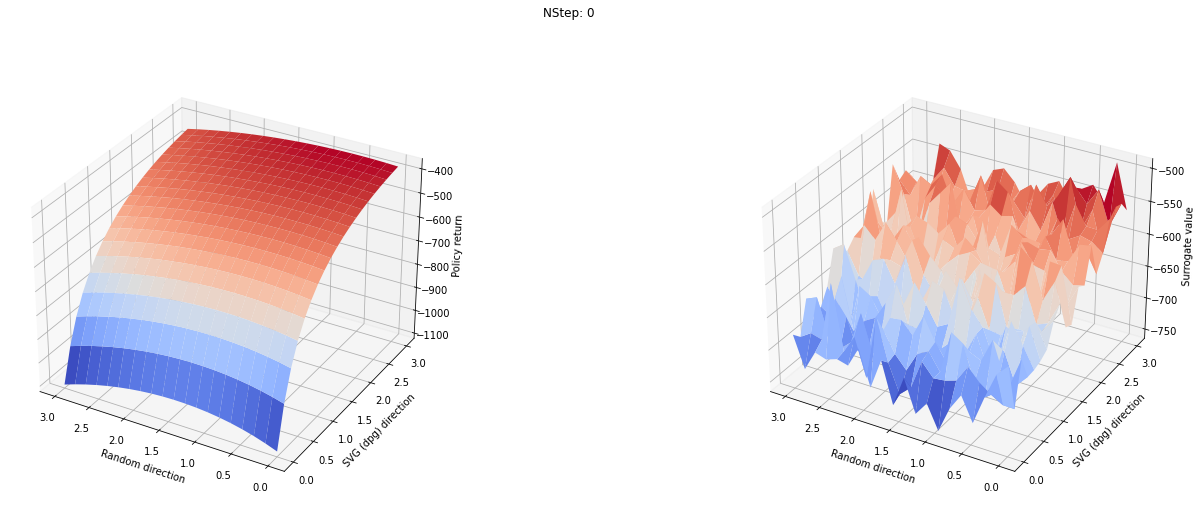

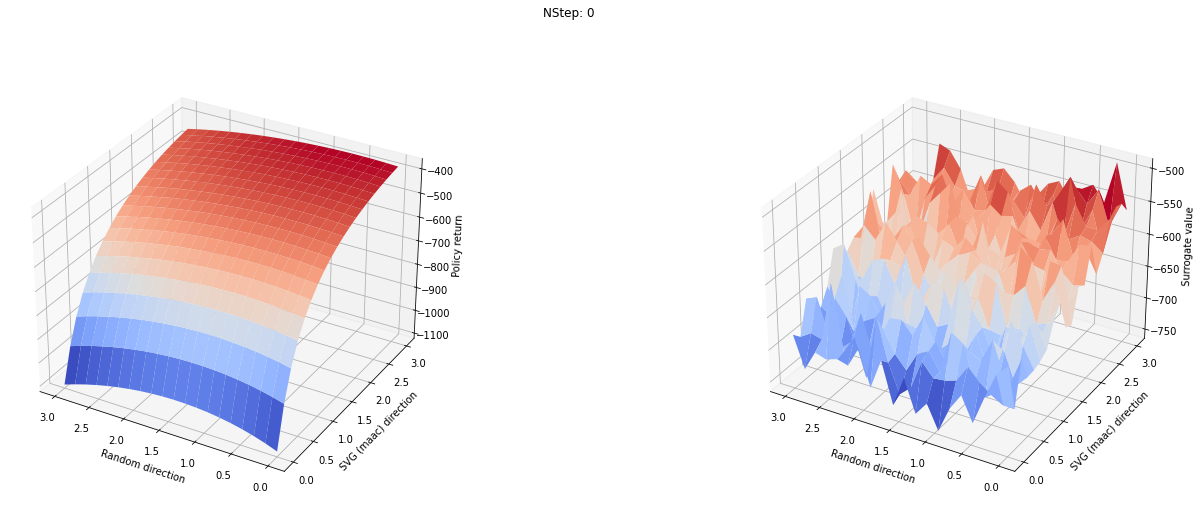

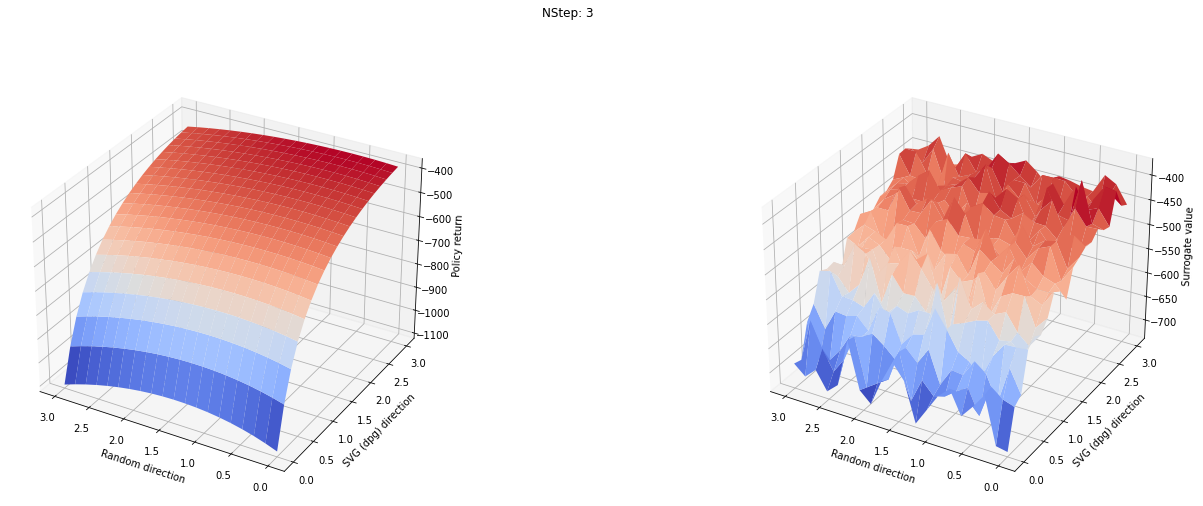

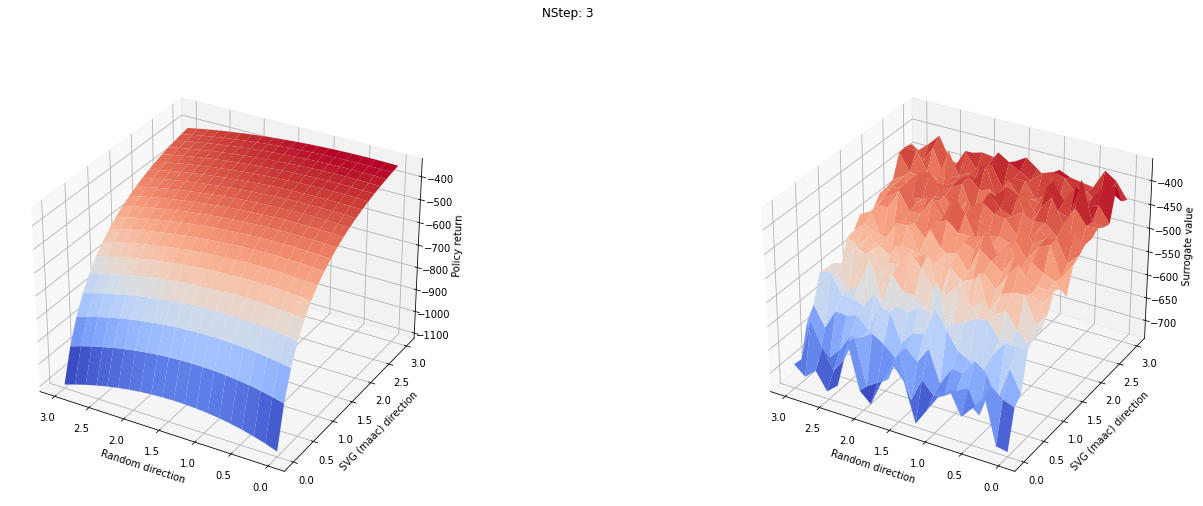

In [9]:
comparator = OptimizationSurfaceComparison(4)
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=0, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=0, seed=4)
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=3, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=3, seed=4)

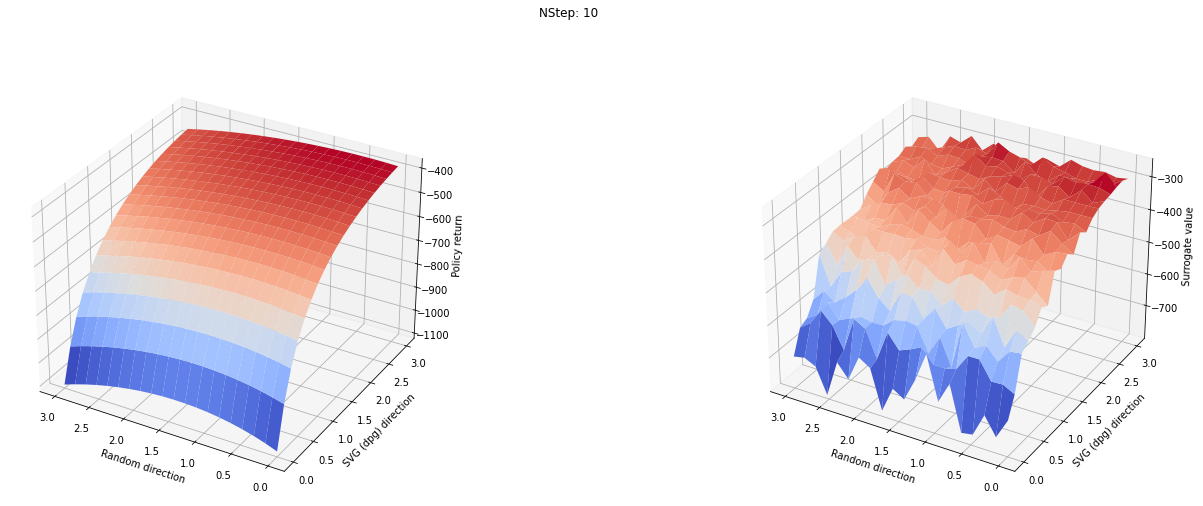

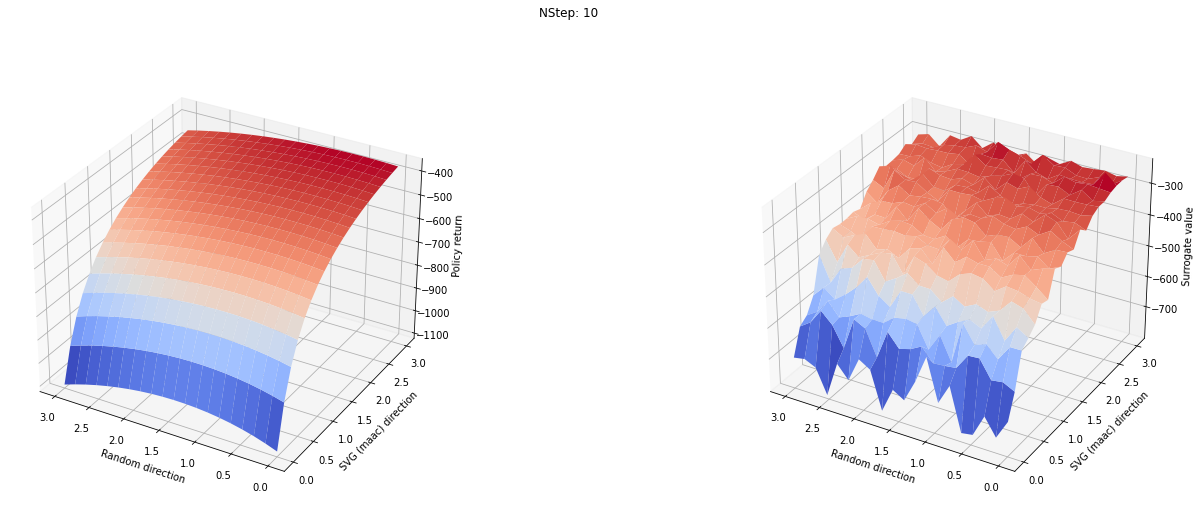

In [10]:
comparator = OptimizationSurfaceComparison(4)
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=10, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=10, seed=4)

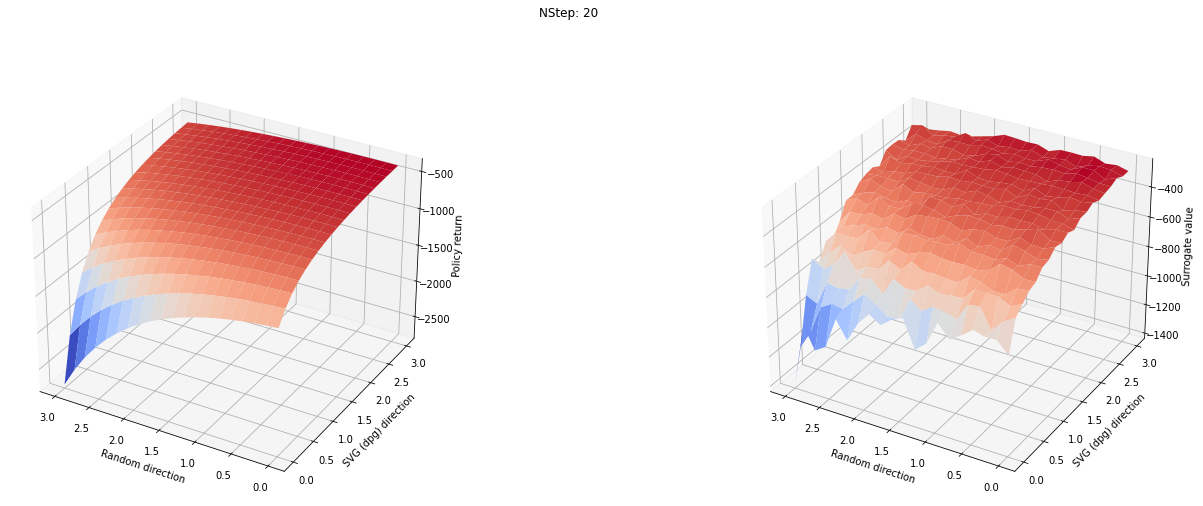

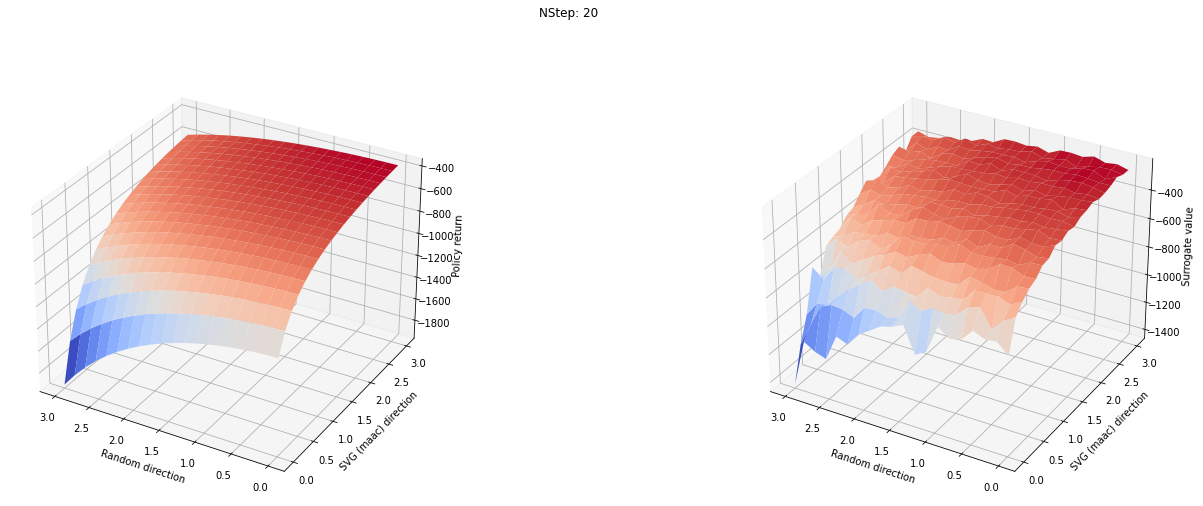

In [11]:
comparator = OptimizationSurfaceComparison(4)
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=20, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=20, seed=4)

In [12]:
# comparator = OptimizationSurfaceComparison(4)
# comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=0, update_q=True)
# comparator.plot_real_vs_surrogate("maac", samples=200, n_step=0, update_q=True)
# comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=3, update_q=True)
# comparator.plot_real_vs_surrogate("maac", samples=200, n_step=3, update_q=True)

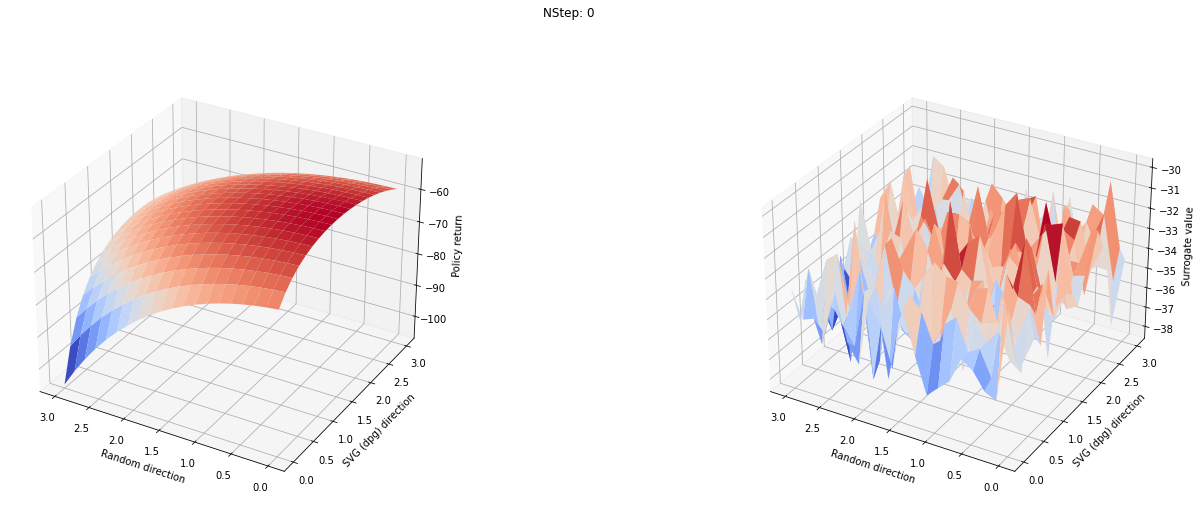

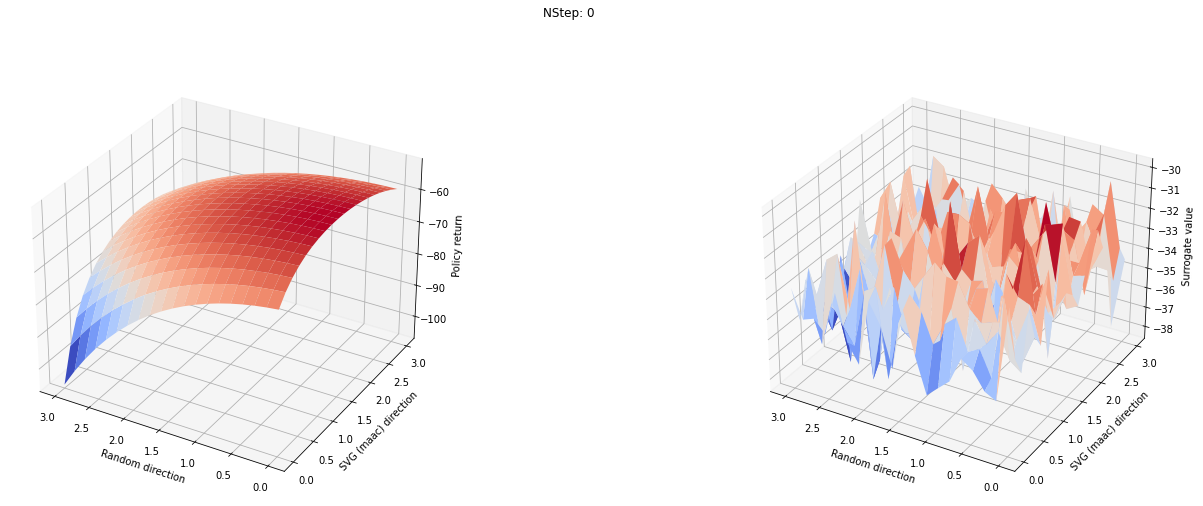

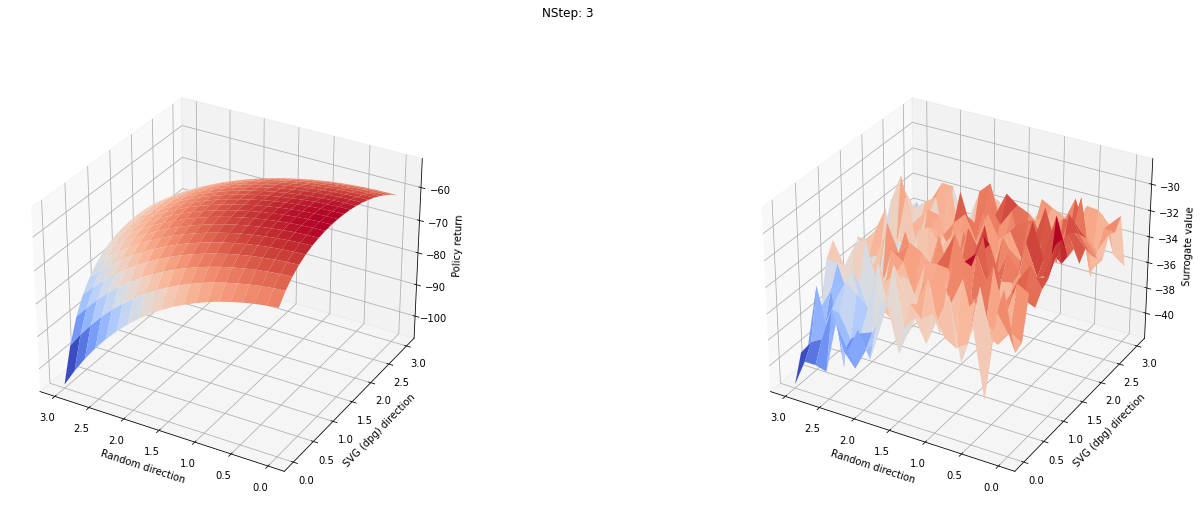

In [ ]:
comparator = OptimizationSurfaceComparison(42)
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=0, seed=42)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=0, seed=42)
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=3, seed=42)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=3, seed=42)

In [ ]:
comparator = OptimizationSurfaceComparison(42)
comparator.plot_real_vs_surrogate("dpg", samples=500, n_step=0, seed=42)
comparator.plot_real_vs_surrogate("maac", samples=500, n_step=0, seed=42)
comparator.plot_real_vs_surrogate("dpg", samples=500, n_step=3, seed=42)
comparator.plot_real_vs_surrogate("maac", samples=500, n_step=3, seed=42)